Right-click the "Open in Colab" badge to see all content: 

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1IsVGT9joaBmBrdz3igp0xboDeXiVCs3H?usp=sharing)

# Architectures Choice: AutoEncoders, Skip Connections, UNets, ResNets,...

TODO: needs more text. ;-) In the meantime, I'll post the video capture below.   

### Scroll wayyy down to find the code for **"Coloring Fashion MNIST Based on Clothing Type"**

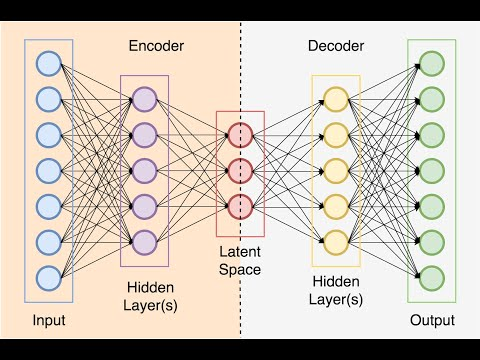

In [82]:
from IPython.display import YouTubeVideo
YouTubeVideo('qYYHSocWEIM')

## Basic Autoencoder

<img src="https://github.com/drscotthawley/DLAIE/blob/main/images/AutoEncoder.png?raw=true" height="300px">

![audio aec](https://raw.githubusercontent.com/drscotthawley/DLAIE/main/images/audio_autoencoder.png) *(Source: [Hawley, Chatziioannou, &amp; Morrison, Acoustics Today, 2020](https://acousticstoday.org/synthesis-of-musical-instrument-sounds-physics-based-modeling-or-machine-learning-scott-h-hawley-vasileios-chatziioannou-and-andrew-morrison/))*

## UNets: Concatenative Skips

<img src="https://fastai1.fast.ai/imgs/u-net-architecture.png" alt="unet architecture" width="100%">

*Source: [fastai vision](https://fastai1.fast.ai/vision.models.unet.html)

Often used for (and first applied to) medical image segmentation: 

<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2020/04/image4-1.jpg" alt="medical image segmentation example" width="100%">

*Source: [NVIDIA](https://developer.nvidia.com/blog/accelerating-medical-image-segmentation-tensor-cores-tensorflow-2/)

## ResNets:  Additive / "Residual" Connections
![residual picture](https://miro.medium.com/max/683/0*0r0vS8myiqyOb79L.jpg)

*Source: [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)*


![resnet_bigger](https://i.imgur.com/mbi6ktD.png)

## Residual Smooths the Los surface

![loss surface image](https://miro.medium.com/max/2000/1*ME5zYSkdsQT3pEIDDGE1Fg.png)

*Source: ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf)

## Inception Models / Block

![inception comparison](https://glassboxmedicine.files.wordpress.com/2020/12/vgg-resnet-googlenet-1.png) 

![inception block](https://miro.medium.com/max/865/0*CJZdXZULMr_on1Ao.jpg)

## Multiplicative Skips: "Skip Filter"

cf. "Gain" connection in SignalTrain Model:

<img src="https://signaltrain.herokuapp.com/model_diagram.png" alt="signaltrain arch image" width="500px">

Source: [Hawley et al](https://www.aes.org/e-lib/browse.cfm?elib=20595)

### Difference that Skips Can Make in Training

![training image for signaltrain](https://pbs.twimg.com/media/DbqPiP_W0AAFX8j?format=jpg&name=900x900)

## ~~Generative Adversarial Networks (GANs)~~
Will save GANs for a later lesson.

~~img src="https://raw.githubusercontent.com/drscotthawley/DLAIE/main/images/audio_gan.jpg" height="500px">~~

~~*(Source: [Hawley, Chatziioannou, &amp; Morrison, Acoustics Today, 2020](https://acousticstoday.org/synthesis-of-musical-instrument-sounds-physics-based-modeling-or-machine-learning-scott-h-hawley-vasileios-chatziioannou-and-andrew-morrison/))*~~


# Example: Coloring Fashion-MNIST Based on Clothing Type

> *i.e, Autoencode Fashion-MNIST*

We're going to make a UNet-style network that will learn to color different types of clothing in the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which consists of tiny 28x28 grayscale images of 10 different types of clothing, such as these examples:

![fashion mnist example](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

**Questions:** "Why would anyone want such a code?? And isn't this overkill anyway? Because Fashion-MNIST is supposed to be used for image classification, so instead of using an autoencorder (overkill), couldn't we just classify the images and THEN colorize them by class?"  

**Answers:** Well,...yeah...but.. this is just supposed to be a simple autoencoder / image translation example. My other idea was to do arithmetic with MNIST.  (We could still do arithmetic with closing, I suppose!)

To start off with the code, let's upgrade fastai on colab and do our imports

In [1]:
! [ -e /content ] && pip install -Uqq fastai  # Colab only: upgrade fastai

     |████████████████████████████████| 189 kB 12.9 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 


In [2]:
from fastai.vision.all import *
import torch
from torchvision import datasets
from fastai.torch_basics import *
from fastdownload import FastDownload
from functools import lru_cache
import fastai.data
import matplotlib.pyplot as plt 
from PIL import Image, ImageOps
from IPython.display import display # to display images
import struct 
import numpy as np 

### Get the data

In [3]:
# download the dataset
ptds = datasets.FashionMNIST('.',download=True) #pytorch dataset object, which we won't actually use

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
path = Path('FashionMNIST/raw')
path.ls()

(#8) [Path('FashionMNIST/raw/train-images-idx3-ubyte'),Path('FashionMNIST/raw/t10k-labels-idx1-ubyte.gz'),Path('FashionMNIST/raw/t10k-labels-idx1-ubyte'),Path('FashionMNIST/raw/train-labels-idx1-ubyte.gz'),Path('FashionMNIST/raw/train-labels-idx1-ubyte'),Path('FashionMNIST/raw/t10k-images-idx3-ubyte'),Path('FashionMNIST/raw/t10k-images-idx3-ubyte.gz'),Path('FashionMNIST/raw/train-images-idx3-ubyte.gz')]

The meanings of these different filenames is explained on [Yann Lecun's Original MNIST web page](http://yann.lecun.com/exdb/mnist/):  

```
train-images-idx3-ubyte.gz:  training set images
train-labels-idx1-ubyte.gz:  training set labels
t10k-images-idx3-ubyte.gz:   test set images 
t10k-labels-idx1-ubyte.gz:   test set labels 
```

We can use the following code to read these files:

In [6]:
# source: https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40

def read_idx_file(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [7]:
test_labels = read_idx_file(Path('FashionMNIST/raw')/'t10k-labels-idx1-ubyte')
test_labels 

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

....except that the [meanings of these digits](https://github.com/zalandoresearch/fashion-mnist#labels) refer to items of clothing: 

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

And let's look at a few images:

In [8]:
test_images = read_idx_file(Path('FashionMNIST/raw')/'t10k-images-idx3-ubyte')
test_images.shape 

(10000, 28, 28)

In [9]:
# the values inside are greyscale intensity values for 28x28 pixels:
print(test_images[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   3   1   0   0   7   0  37   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   2   

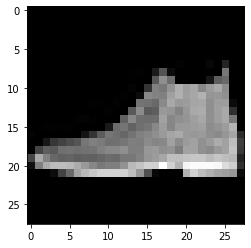

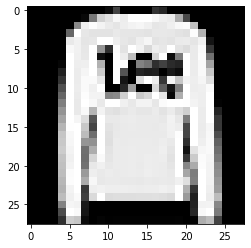

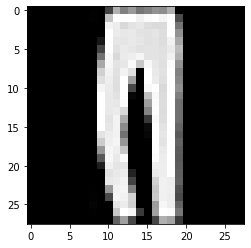

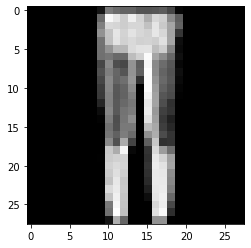

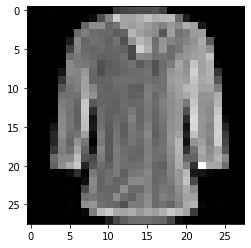

In [10]:
# we can also plot them:
for i in range(5): 
    plt.imshow(test_images[i], cmap='gray')
    plt.show() 

...although note that these are really tiny 28x28 pixel images. 

Now...to make things easier as we go on, what I want to do first is to make the file structure of this look more like  the relevant fastai example. Although I don't think the fastai MNIST example is appropriate. Instead, the idea that I've dreamed up for Fashion MNIST is for the autoencoder to color different items by their class -- i.e, it'll be a really simple image segmentation problem. The fastai example dataset for segmentation is called CAMVID. Let's take a look at the setup of the CAMVID_TINY dataset provided by fastai, and then we can make our Fashion MNIST dataset mimic that:

In [11]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/codes.txt')]

The input images are just called 'images':

In [12]:
!ls {path/ 'images'}

0001TP_006750.png  0006R0_f03210.png  0016E5_07979.png	  Seq05VD_f00990.png
0001TP_006840.png  0006R0_f03240.png  0016E5_07995.png	  Seq05VD_f01080.png
0001TP_007500.png  0006R0_f03330.png  0016E5_07997.png	  Seq05VD_f01260.png
0001TP_007860.png  0006R0_f03450.png  0016E5_08001.png	  Seq05VD_f01320.png
0001TP_008070.png  0006R0_f03630.png  0016E5_08009.png	  Seq05VD_f01440.png
0001TP_008160.png  0006R0_f03720.png  0016E5_08057.png	  Seq05VD_f01830.png
0001TP_008400.png  0016E5_00720.png   0016E5_08085.png	  Seq05VD_f01890.png
0001TP_008580.png  0016E5_00840.png   0016E5_08089.png	  Seq05VD_f01950.png
0001TP_008670.png  0016E5_01260.png   0016E5_08093.png	  Seq05VD_f02070.png
0001TP_008700.png  0016E5_01500.png   0016E5_08101.png	  Seq05VD_f02370.png
0001TP_008760.png  0016E5_01920.png   0016E5_08125.png	  Seq05VD_f02640.png
0001TP_008940.png  0016E5_02250.png   0016E5_08137.png	  Seq05VD_f02880.png
0001TP_009000.png  0016E5_05190.png   0016E5_08141.png	  Seq05VD_f02940.png
0001TP_00915

The output images are called 'labels', and all the files there match the corresponding input imaages except the labels have a `_P` in the filename:

In [13]:
!ls {path / 'labels'}

0001TP_006750_P.png  0016E5_01500_P.png  0016E5_08550_P.png
0001TP_006840_P.png  0016E5_01920_P.png  Seq05VD_f00000_P.png
0001TP_007500_P.png  0016E5_02250_P.png  Seq05VD_f00090_P.png
0001TP_007860_P.png  0016E5_05190_P.png  Seq05VD_f00210_P.png
0001TP_008070_P.png  0016E5_05310_P.png  Seq05VD_f00420_P.png
0001TP_008160_P.png  0016E5_05730_P.png  Seq05VD_f00480_P.png
0001TP_008400_P.png  0016E5_05940_P.png  Seq05VD_f00810_P.png
0001TP_008580_P.png  0016E5_06090_P.png  Seq05VD_f00990_P.png
0001TP_008670_P.png  0016E5_06240_P.png  Seq05VD_f01080_P.png
0001TP_008700_P.png  0016E5_06300_P.png  Seq05VD_f01260_P.png
0001TP_008760_P.png  0016E5_06570_P.png  Seq05VD_f01320_P.png
0001TP_008940_P.png  0016E5_06810_P.png  Seq05VD_f01440_P.png
0001TP_009000_P.png  0016E5_06870_P.png  Seq05VD_f01830_P.png
0001TP_009150_P.png  0016E5_06990_P.png  Seq05VD_f01890_P.png
0001TP_009360_P.png  0016E5_07290_P.png  Seq05VD_f01950_P.png
0001TP_009840_P.png  0016E5_07973_P.png  Seq05VD_f02070_P.png
0001TP_009

...and then theres the `codes` file that tells you what the colors of each pixel will mean, where the number of the row (not shown) will serve as the index. But we already know our codes:

In [14]:
codes = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag', 9:'Ankle boot'}

### Generate our CAMVID-style Fashion MNIST segmentation dataset
Now watch as we make our own Fashion-MNIST version of the CAMVID dataset: ;-) 

In [15]:
# set up directories
newpath = path.parent /'fashion_mnist'
!rm -rf {newpath}
newpath.mkdir()
image_path, label_path = newpath /'images', newpath / 'labels'
image_path.mkdir() 
label_path.mkdir() 

What we're going to do now is go through every image, save the original in `images/` then colorize it accoring to which class it is and save the result in `labels/`.  And we'll go ahead an merge the `train` and `test` directories and let fastai do our train-val split later:

In [16]:
train_labels = read_idx_file(Path('FashionMNIST/raw')/'train-labels-idx1-ubyte')
train_images = read_idx_file(Path('FashionMNIST/raw')/'train-images-idx3-ubyte')
images = np.vstack((train_images, test_images))
labels = np.hstack((train_labels, test_labels))
images.shape, labels.shape 

((70000, 28, 28), (70000,))

And let's make a little function to colorize the image according to the class number.  Essentially we'll make the image pixel values the intensity of one of 10 hues:


8 Bag: (28, 28) -> (28, 28, 3)


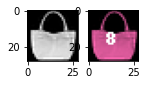


0 T-shirt/top: (28, 28) -> (28, 28, 3)


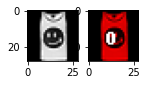


1 Trouser: (28, 28) -> (28, 28, 3)


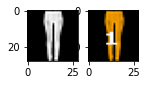


6 Shirt: (28, 28) -> (28, 28, 3)


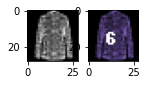


9 Ankle boot: (28, 28) -> (28, 28, 3)


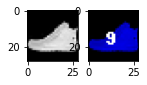


7 Sneaker: (28, 28) -> (28, 28, 3)


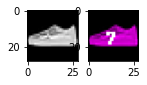


3 Dress: (28, 28) -> (28, 28, 3)


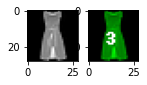


5 Sandal: (28, 28) -> (28, 28, 3)


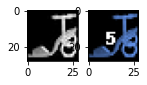


4 Coat: (28, 28) -> (28, 28, 3)


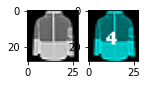


2 Pullover: (28, 28) -> (28, 28, 3)


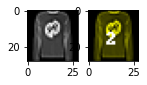

In [93]:


colors = ["red", "orange",  "yellow",  "lime",  "cyan", "cornflowerblue", "mediumpurple",  "magenta", "hotpink", "blue"]

from PIL import ImageDraw
from PIL import ImageFont


def draw_text(img, text):
    ImageDraw.Draw(img).text( (10, 10), text, (255,255,255))
    return img 


def color_it(grayscale_img, class_num, draw_num=False):
    img = Image.fromarray(grayscale_img)
    img = ImageOps.colorize(img, black ="black", white = colors[class_num])
    if draw_num: img = draw_text(img, strclass_num))  # for added difficulty!! ;-) 
    return img 

## Extra hard thing to try:
draw_numbers = True   # setting this to true draws the class number on the output image. makes it harder than just colorizing 

# let's show off one of each class 
shown_already = []
for i in range(100):  # 100 should be enough to feature one of each:
    i = i + 100
    if len(shown_already) == 10: break
    label, code = labels[i], codes[labels[i]]
    if (label not in shown_already):   
        img1 = color_it(images[i],label, draw_num=draw_numbers)       
        print(f"\n{label} {code}: {np.array(Image.fromarray(images[i])).shape} -> {np.array(img1).shape}")
        shown_already.append(label)
        fig, ax = plt.subplots(1,2, figsize=(2,1))
        ax[0].imshow(images[i], cmap='gray');
        ax[1].imshow(img1);
        #display(img1)
        plt.show()


New we're ready to write to our new dataset!  This will take about a minute to run:

In [94]:
for i in range(labels.shape[0]):
    # how about if we start with the image's unique number and follow with the class number
    filename = f"{i}_{labels[i]}" 
    out_image = color_it(images[i], labels[i], draw_num=draw_numbers)
    in_image = Image.fromarray(images[i]).convert('RGB')   # go ahead and make it a full RGB image even though it's grayscale
    in_image.save(str(image_path)+'/'+filename+'.png')  # save...
    out_image.save(str(label_path)+'/'+filename+'_P.png')
    if (i+1) % 10000 == 0: 
        print(f"Just saved image {i+1} of {len(labels)}: {filename} ({codes[labels[i]]})")
        display(out_image)


Just saved image 10000 of 70000: 9999_6 (Shirt)


Just saved image 20000 of 70000: 19999_4 (Coat)


Just saved image 30000 of 70000: 29999_8 (Bag)


Just saved image 40000 of 70000: 39999_0 (T-shirt/top)


Just saved image 50000 of 70000: 49999_7 (Sneaker)


Just saved image 60000 of 70000: 59999_5 (Sandal)


Just saved image 70000 of 70000: 69999_5 (Sandal)


Now we're ready to define our model.  Although.... one more thing: fastai likes to have a function called `get_y` that will convert an input filename to an output filename. So we'll do that:

In [95]:
def get_y(in_name): 
    return str(in_name).replace('images','labels').replace('.png','_P.png')

In [96]:
# tests to make sure get_y works:
in_name = sorted((newpath / 'images').ls())[0]
out_name = sorted((newpath / 'labels').ls())[0]
print(str(in_name)," goes to...")
print(get_y(in_name))  # should be the same as ...
print(str(out_name))  # should be the same ^

assert get_y(in_name) == str(out_name)  # did we get the same thing?
assert out_name.is_file()  # does this out file really exist on the disk?

/root/.fastai/data/fashion_mnist/images/0_9.png  goes to...
/root/.fastai/data/fashion_mnist/labels/0_9_P.png
/root/.fastai/data/fashion_mnist/labels/0_9_P.png


# Define Fastai Dataset

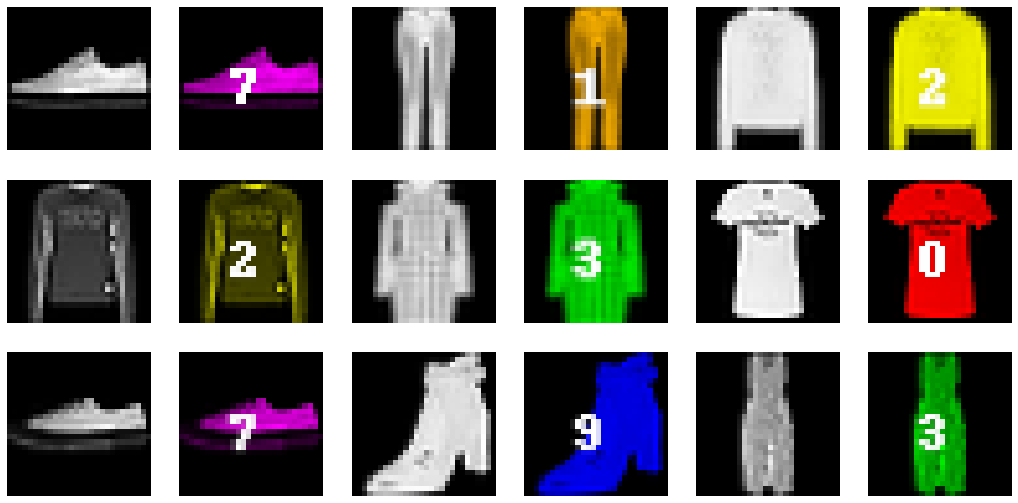

In [100]:
# Drawing numbers limits our data augmentation options, sadly. 
if draw_numbers: # don't flip, warp or rotate if we're trying to draw numbers
    tmfs = *aug_transforms(do_flip=False, max_warp=0.0, max_rotate=0) if draw_numbers else *aug_transforms()

fmnist_block = DataBlock(blocks=(ImageBlock, ImageBlock),  # map from image to image
                   get_items=get_image_files,   # get_image_files is part of fastai 
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   batch_tfms=[IntToFloatTensor(), tmfs, Normalize()])

dls = fmnist_block.dataloaders(newpath/'images', bs=64)
dls.show_batch()

In [101]:
# let's define an accuracy metric that just compares (colors of) pixels
def acc_fmist(pred, targ, tol=1.0):
    where_correct = (pred-targ).abs() < tol  # 1's wherever we're within tolerance, 0's elsewhere
    return torch.flatten(where_correct).float().mean()

### Define the Learner

In [102]:
opt = ranger
learn = unet_learner(dls, resnet34, loss_func=MSELossFlat(), n_out=3, # output 3 color channels
                     self_attention=True, metrics=acc_fmist, act_cls=Mish, opt_func=opt)

SuggestedLRs(valley=0.00010964782268274575)

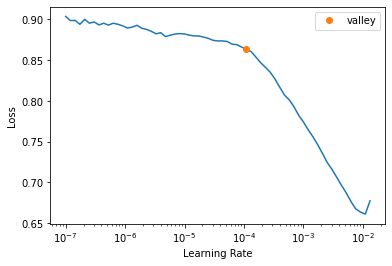

In [103]:
learn.lr_find()

### Train the model 

In [104]:
lr = 1e-4
learn.fit_flat_cos(5, slice(lr))  # this will take ~2 minutes per epoch on Colab

epoch,train_loss,valid_loss,acc_fmist,time
0,0.113485,0.110132,0.972850,02:04
1,0.091010,0.086052,0.979278,01:58
2,0.081475,0.077625,0.980831,01:58
3,0.071824,0.065116,0.983887,01:58
4,0.064305,0.060037,0.985073,02:00


In [105]:
learn.save('fmnist-1') # save a checkpoint
learn.load('fmnist-1')

The training above was with key parts of the model frozen.  Let's unfreeze and train a little longer...

In [110]:
# now shrink learning rate(s) and unfreeze, then train some more
lrs = slice(lr/400, lr/4)
learn.unfreeze()

In [111]:
learn.fit_flat_cos(5, lrs)

epoch,train_loss,valid_loss,acc_fmist,time
0,0.061773,0.060503,0.984899,02:03
1,0.060160,0.058704,0.985290,02:04
2,0.060015,0.057715,0.985419,02:04
3,0.058024,0.057145,0.985282,02:04
4,0.054439,0.055828,0.985901,02:04


...and we could keep training longer to see how much better we can do, but this is pretty good for now. ;-) 

In [114]:
learn.save('fmnist-2') # save a checkpoint for the unfrozen training result
learn.load('fmnist-2')

Let's make a pair of Target/Prediction columns:

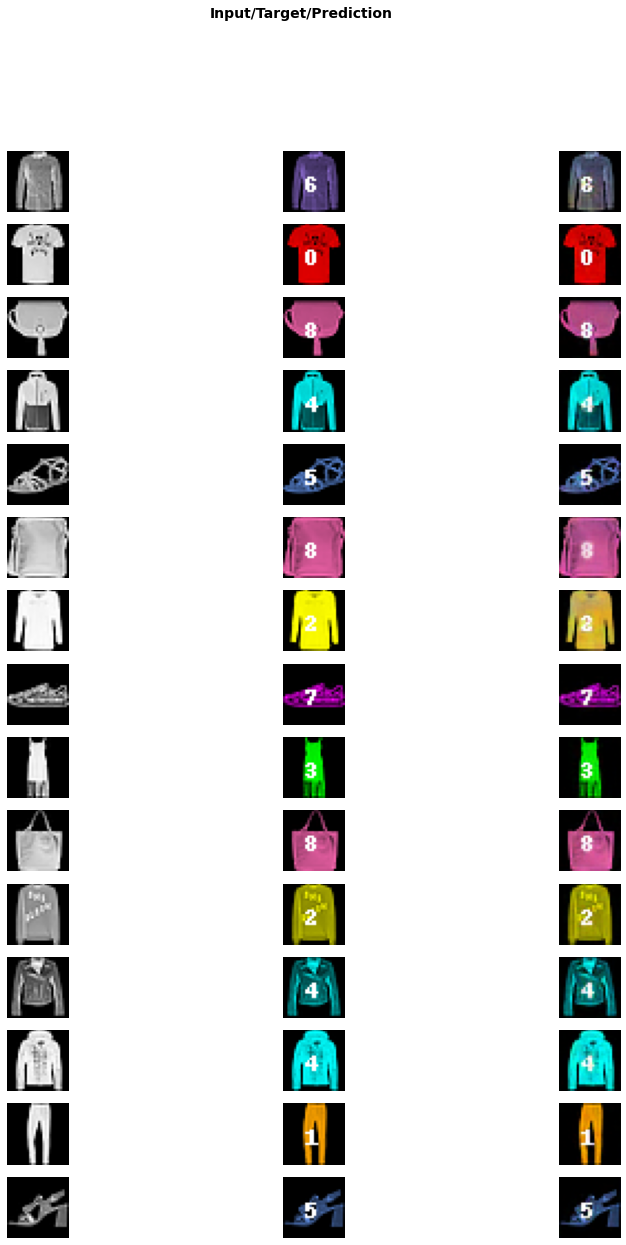

In [115]:
learn.show_results(max_n=15, figsize=(14,20))

If you keep running `learn.show_results()` over and over again, you'll notice the occasional mistake, such as a dress with arms that gets mistaken for a shirt, or a shirt that gets mistaken for a coat, etc., but on the whole it does pretty well!

**TODO:** Write a really awful, inefficient UNet/autoencoder model lacking skip connections, to show how significant they are...?

**What I'd rather see someone try:** 
Go up to the part where it's writing the digit on the image, but replace that with some kind of integer (mod 10) arithmetic operation. ;-) 